# I.Milestone: Data Discovery and preprocessing steps

This notebook is intended as a presentation of milestone 1 of the major homework assignment of the course Deep Learning in Practice based on Python and LUA (BMEVITMAV45).
The aim of this project is to generate audio files based on brain signals using Machine Learning based algorithms. We are using the following article as a reference: https://www.nature.com/articles/s41597-022-01542-9. The preprocessing steps such as filtering and channel selection have been taken from their work, which can be found in SingleWordProductionDutch submodule.

## Installs and import

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import os
from typing import List

from data_discovery_helpers.Participant import Participant
from data_discovery_helpers.NWBData import NWBData
from data_discovery_helpers.PreProcessedData import PreProcessedData
import glob
import zipfile
import requests
import io
import numpy as np
import wavfile

#from create_dataloaders import create_dataloaders

## 1. Original dataset

The dataset we used can be found here: https://osf.io/nrgx6/. In short there was an experiment where 10 participants were speaking prompted  German words aloud while audio and intracranial EEG data were recorded simultaneously as it can be seen in the figure below.
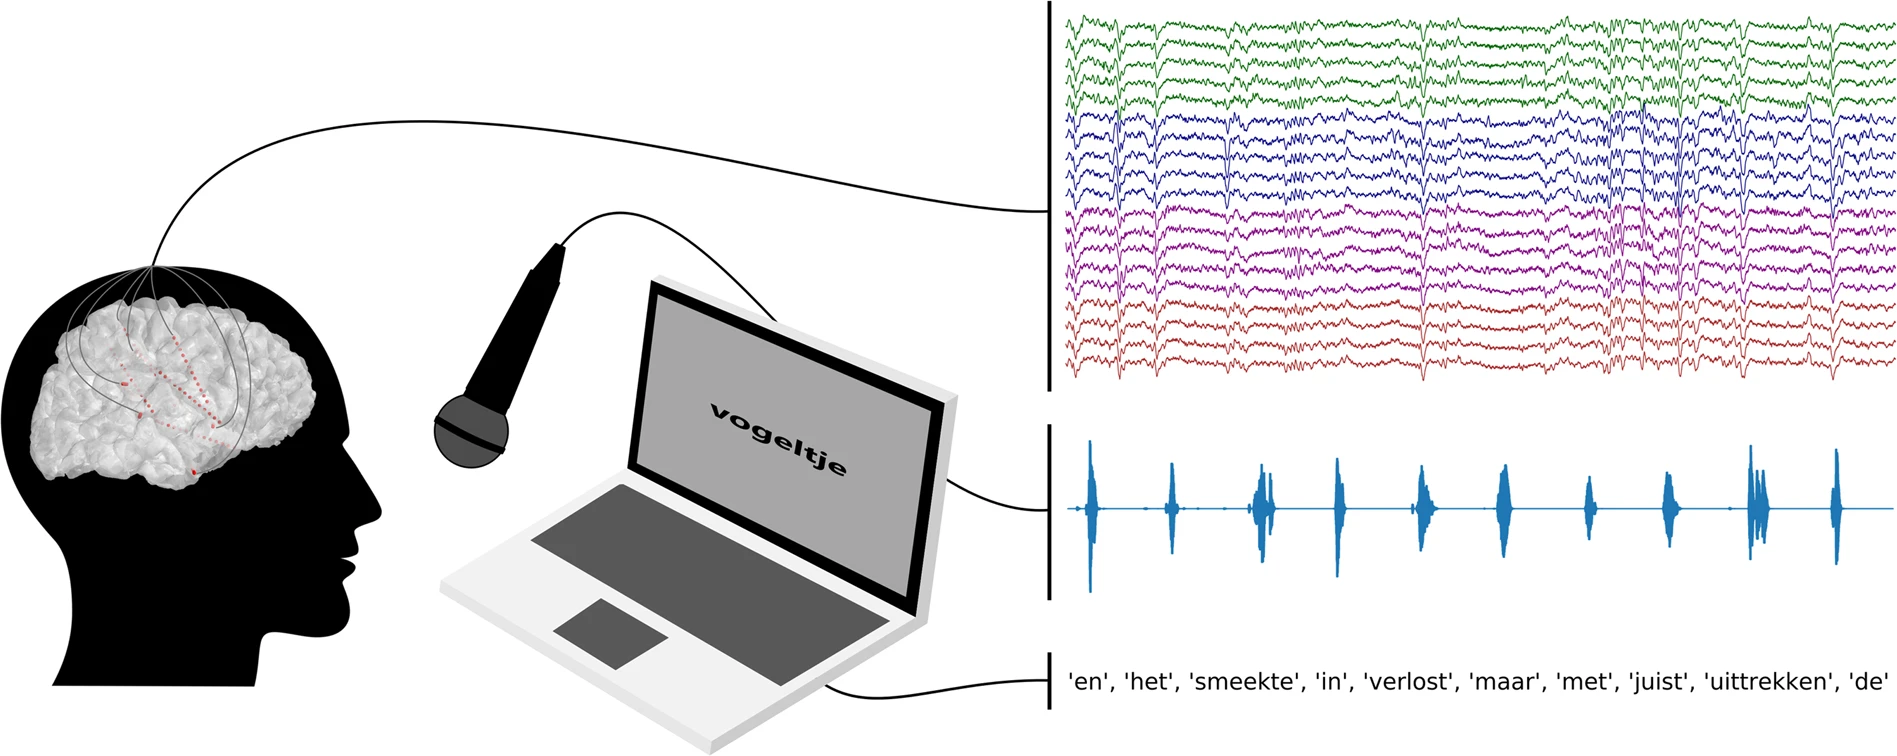
The raw data files (XDF format) were converted to Neurodata Without Borders (NWB; https://www.nwb.org/) format and organised in the iBIDS data structure format using custom Python scripts. The NWB format allows for compact storage of multiple data streams within a single file. It is compatible to the iBIDS structure, a community-driven effort to improve the transparency, reusibility and reproducibility of iEEG data.
In the data structure you will find a general information about the participants and in separate folders the measurements for each subject. The latter includes information about the implanted electrodes, event markers and 3 channels with timestamps: iEEG, Audio and Stimulus (words). The dimensions of all 3 channels depend on the length of the recordings, furthermore the iEEG diemnsion also depends on the number of impanted and working electrodes.

In [16]:
#downloading zip file
r = requests.get("https://osf.io/download/g6q5m")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

### Loading participant info

In [4]:
DEFAULT_PATH_BIDS = r'./SingleWordProductionDutch-iBIDS'
DEFAULT_FEATURES_PATH = r'./features'
pd_participants = pd.read_csv(os.path.join(DEFAULT_PATH_BIDS,'participants.tsv'), delimiter='\t')

In [5]:
participants = [Participant(pd_participants.iloc[p_idx],p_idx) for p_idx in range(pd_participants.shape[0])]

In [6]:
p_ids = [p.get_model().participant_id for p in participants]

In [7]:
print(p_ids)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']


In [8]:
for p in participants:
    print(p.get_model())

p_idx=0 participant_id='sub-01' age=20 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=1 participant_id='sub-02' age=43 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=2 participant_id='sub-03' age=24 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=3 participant_id='sub-04' age=46 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=4 participant_id='sub-05' age=50 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=5 participant_id='sub-06' age=16 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=6 participant_id='sub-07' age=47 sex=<SexEnum.MALE: 'Male'> hand=nan
p_idx=7 participant_id='sub-08' age=22 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=8 participant_id='sub-09' age=20 sex=<SexEnum.FEMALE: 'Female'> hand=nan
p_idx=9 participant_id='sub-10' age=36 sex=<SexEnum.MALE: 'Male'> hand=nan


The 10 participants were suffering from pharmaco-resistant epilepsy (mean age 32 years (range 16–50 years); 5 male, 5 female). The implantation of sEEG electrodes was part of their therapy for epilepsy so electrode locations were purely determined based on clinical necessity.

### Loading NWBData

In [9]:
nwb_datas: List[NWBData] = []

for participant in participants:
    participant_id = participant.get_model().participant_id
    nwb_datas.append(NWBData(participant_id,path_bids=DEFAULT_PATH_BIDS))

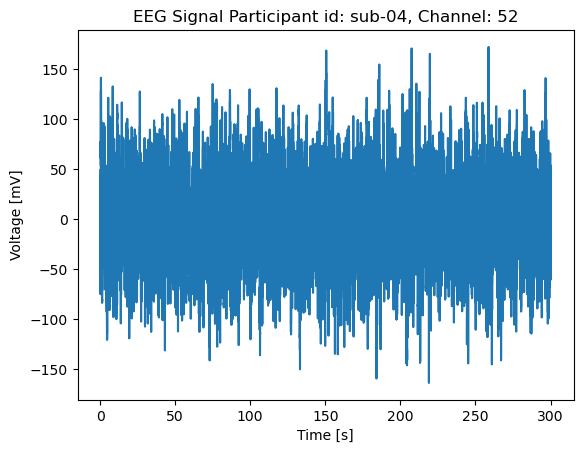

In [10]:
nwb_datas[3].display_eeg_signal(52)

## 2. Extracting features

Feature extraction of iEEg Data (applied to all electrode channels):<br>
    &emsp;1. Bandpass filtering 70-170 Hz to extract High-Gamma Band (IIR filter, order 4)<br>
    &emsp;2. Bandstop filtering 98-102 Hz to attenuate first harmonic of line noise (IIR filter, order 4)<br>
    &emsp;3. Bandstop filtering 148-152 Hz to attenuate first harmonic of line noise (IIR filter, order 4)<br>
    &emsp;4. Hilbert transform to get the envelope of the signal<br>
    &emsp;5. Averageing in frequency domain with 50 ms window and 10 ms frameshift<br>
    &emsp;6. Stacking non-overlapping neighboring windows up to 200 ms to include temporal information<br>
    <br>
    <br>
Feature extraction of audio Data:<br>
    &emsp;1. Downsampling to 16 kHz<br>
    &emsp;2. Applying short-term-fourier-transform in windows of 50 ms with an frameshift of 10 ms to get the spectogram<br>
    &emsp;3. Converting spectogram to log-mel representation <br>
    


In [18]:
!pip install pandas scipy pynwb

     -------------------------------------- 126.6/126.6 kB 3.8 MB/s eta 0:00:00
     ------------------------------------- 392.4/392.4 kB 23.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ------------------------------------- 187.5/187.5 kB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 83.8/83.8 kB 4.6 MB/s eta 0:00:00
  Using cached ruamel.yaml-0.17.21-py3-none-any.whl (109 kB)
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
Failed to build h5py


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [5080 lines of output]
  --- Logging error ---
  Traceback (most recent call last):
    File "C:\Python311\Lib\logging\__init__.py", line 1113, in emit
      stream.write(msg + self.terminator)
  ValueError: underlying buffer has been detached
  Call stack:
    File "C:\Python311\Lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 351, in <module>
      main()
    File "C:\Python311\Lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 333, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Python311\Lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 249, in build_wheel
      return _build_backend().build_wheel(wheel_directory, config_settings,
    File "C:\Users\Zsombi\AppData\Local\Temp\pip-build-env-f2brm3iu\overlay\Lib\site-packages\setuptools\build_meta.py", line 412, in build_wheel
      return self._build_with_temp_dir(['bdist_wheel'], '

In [17]:
!python SingleWordProductionDutch/extract_features.py

Traceback (most recent call last):
  File "C:\git\BRAIN2SPEECH_LesssGoo\SingleWordProductionDutch\extract_features.py", line 12, in <module>
    from pynwb import NWBHDF5IO
ModuleNotFoundError: No module named 'pynwb'


#### Hilbert transform demo
from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp

def hilbert_demo():
    duration = 1.0
    fs = 400.0
    samples = int(fs*duration)
    t = np.arange(samples) / fs
    
    signal = chirp(t, 20.0, t[-1], 100.0)
    signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
    
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                               (2.0*np.pi) * fs)
    
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    ax0.plot(t, signal, label='signal')
    ax0.plot(t, amplitude_envelope, label='envelope')
    ax0.set_xlabel("time in seconds")
    ax0.legend()
    ax1.plot(t[1:], instantaneous_frequency)
    ax1.set_xlabel("time in seconds")
    ax1.set_ylim(0.0, 120.0)
    fig.tight_layout()

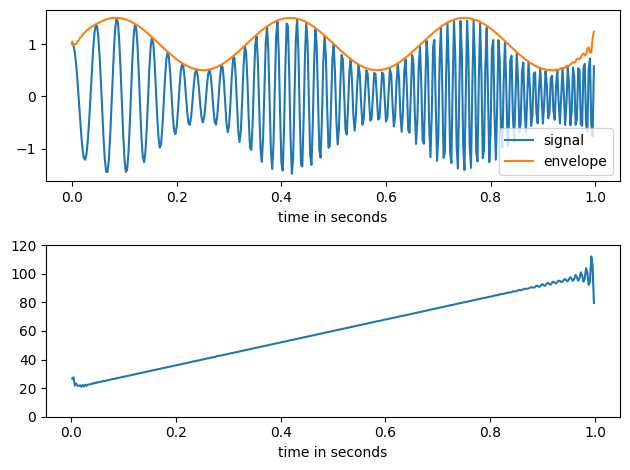

In [20]:
hilbert_demo()

### 3. Visualizing preprocessed data

In [19]:
preprocessed_ds = []
for p_id in p_ids:
    preprocessed_ds.append(PreProcessedData(p_id,DEFAULT_FEATURES_PATH))

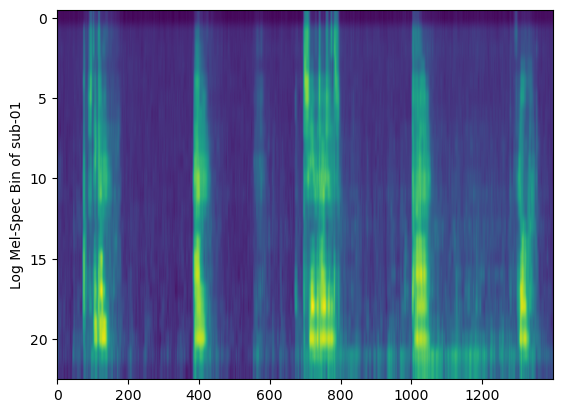

In [20]:
preprocessed_ds[0].display_spectogram()

In [21]:
for pre_ds in preprocessed_ds:
    model = pre_ds.get_model()
    print(f"Participant: {model.p_id}")
    print(f"Feature shape: {model.features.shape}")
    print(f"Spectogram shape: {model.spectogram.shape}")
    print()

Participant: sub-01
Feature shape: (29985, 1143)
Spectogram shape: (29985, 23)

Participant: sub-02
Feature shape: (29985, 1143)
Spectogram shape: (29985, 23)

Participant: sub-03
Feature shape: (29986, 1143)
Spectogram shape: (29986, 23)

Participant: sub-04
Feature shape: (29986, 1035)
Spectogram shape: (29986, 23)

Participant: sub-05
Feature shape: (29984, 540)
Spectogram shape: (29984, 23)

Participant: sub-06
Feature shape: (29993, 1143)
Spectogram shape: (29993, 23)

Participant: sub-07
Feature shape: (29991, 1143)
Spectogram shape: (29991, 23)

Participant: sub-08
Feature shape: (29992, 486)
Spectogram shape: (29992, 23)

Participant: sub-09
Feature shape: (29993, 1053)
Spectogram shape: (29993, 23)

Participant: sub-10
Feature shape: (28460, 1098)
Spectogram shape: (28460, 23)



Dimensions doesn't match!

## 4. Creating DataLoaders

In [22]:
from create_dataloaders import main
train_dl,val_dl,test_dl = main()

In [25]:
feats, spec = next(iter(train_dl))

C:\git\BRAIN2SPEECH_LesssGoo\spectogram_dataset.py:23: RuntimeWarning: invalid value encountered in true_divide
  input = (self.features[index:index+self.window,:]-self.train_mean)/self.train_std


In [28]:
print(feats.shape)
print(spec.shape)

torch.Size([32, 3, 4860])
torch.Size([32, 3, 23])


## 5. Reconstruct Wav file from spectrogram

The following code snippet is from SingleWordProductionDutch. Using this the spectrogram can be converted into a numpy.ndarray representation of a wavfile.

In [45]:
import SingleWordProductionDutch.reconstructWave as rW
import SingleWordProductionDutch.MelFilterBank as mel

def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    """
    Create a reconstructed audio wavefrom
    
    Parameters
    ----------
    spectrogram: array
        Spectrogram of the audio
    sr: int
        Sampling rate of the audio
    windowLength: float
        Length of window (in seconds) in which spectrogram was calculated
    frameshift: float
        Shift (in seconds) after which next window was extracted
    Returns
    ----------
    scaled: array
        Scaled audio waveform
    """
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    nfolds = 10
    hop = int(spectrogram.shape[0]/nfolds)
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled